<a href="https://colab.research.google.com/github/Giancarloff/Gerencia_de_Dados/blob/main/Ger%C3%AAncia_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Scraping

###### Consultar qual servidor do Colab estou usando

In [ ]:
!curl ipinfo.io

{
  "ip": "34.106.1.87",
  "hostname": "87.1.106.34.bc.googleusercontent.com",
  "city": "Salt Lake City",
  "region": "Utah",
  "country": "US",
  "loc": "40.7608,-111.8911",
  "org": "AS396982 Google LLC",
  "postal": "84101",
  "timezone": "America/Denver",
  "readme": "https://ipinfo.io/missingauth"
}

#### GOG


##### Scraper GOG (Backup)

In [ ]:
############################################################
# Você deve rodar a próxima célula, esta daqui é um backup #
############################################################

import requests
import json
import datetime
from bs4 import BeautifulSoup
from bs4.element import NavigableString, Tag
import time
import re


MAX_PAGES = 1  # total de páginas do catálogo, são 209
catalogue = []
index = 0

for pagina in range(1, MAX_PAGES + 1):
    GOG_URL = f"https://www.gog.com/en/games?order=asc:title&page={pagina}"
    print(f"\nFazendo requisição para a página {pagina} ({GOG_URL})...")

    try:
        requisicao = requests.get(GOG_URL)
        requisicao.raise_for_status()
        conteudo = requisicao.content
        print("Requisição feita com sucesso.")
    except Exception as e:
        print(f"Falha ao carregar a página {pagina}: {e}")
        break

    site = BeautifulSoup(conteudo, "html.parser")

    # Pegando os itens do catálogo (nesta página)
    product_tiles = site.find_all("product-tile")
    lenpt = len(product_tiles)
    print(f"Extraindo os dados dos {lenpt} itens desta página...")

    for pt in product_tiles:
        print(f"  [{index + 1}]")

        # URL para página do jogo
        game_url = pt.find("a", {"selenium-id": "productTile"})
        print(game_url.attrs['href'])

        # Dados do jogo
        description_text = ""

        # Requisitando a página do jogo e pegando as informações
        requisicao2 = requests.get(game_url.attrs['href'])
        requisicao2.raise_for_status()
        conteudo2 = requisicao2.content
        print("Requisição (URL Jogo) feita com sucesso.")

        pagina_jogo = BeautifulSoup(conteudo2, "html.parser")
        description_node = pagina_jogo.find("div", class_="description")
        if description_node is not None:
          description_text = description_node.get_text(separator="\n", strip=True)
        else:
          print("description_node is None!")

        details_node = pagina_jogo.find("div", attrs={"content-summary-section-id": "productDetails"})
        genre = []
        tags = []
        supported_os = []
        release_date = None
        developers = []
        size = ""

        if details_node:
          detail_labels = details_node.find_all("div", attrs = {"class" : ["details__category", "table__row-label"]})
          detail_children = details_node.find_all("div", attrs = {"class" : ["details__content", "table__row-content"]})
          for i, label in enumerate(detail_labels):
            label_text = label.get_text().strip()

            if label_text == "Genre:":
              for a in detail_children[i].find_all("a"):
                genre.append(str(a.get_text().strip()))

            elif label_text == "Tags:":
              for a in detail_children[i].find_all("a"):
                tags.append(str(a.get_text().strip()))

            elif label_text == "Works on:":
              supported_os = detail_children[i].get_text().strip()

            elif label_text == "Release date:":
              release_date_raw = detail_children[3].find("span").get_text().strip()
              matchre = re.search(r"'([\d\-T:+]+)'", release_date_raw)
              if matchre:
                  iso = matchre.group(1)  # 2025-04-16T00:00:00+03:00

              release_date = datetime.datetime.fromisoformat(iso).strftime("%d %B %Y")

            elif label_text == "Company:":
              for a in detail_children[i].find_all("a"):
                if a.get_text().strip() not in developers:
                  developers.append(str(a.get_text().strip()))

            elif label_text == "Size:":
              size = detail_children[i].get_text().strip().replace("\"", "")

        # Título
        name_el = pt.find("div", {"selenium-id": "productTileGameTitle"})
        name = name_el.attrs["title"] if name_el else "[Título Não Encontrado]"

        # Desconto
        discount_raw = pt.find("price-discount")
        discount = discount_raw.text if discount_raw else "0%"

        # Preço
        prices_raw = pt.find("price-value", {"selenium-id": "productPriceValue"})
        prices = {"base_price": None, "actual_price": None}
        if prices_raw:
            for span in prices_raw.find_all("span"):
                classes = span.attrs.get("class", [])
                if any("base-value" in c for c in classes):
                    prices["base_price"] = span.text
                elif any("final-value" in c for c in classes):
                    prices["actual_price"] = span.text
        if prices["base_price"] is None:
            prices["base_price"] = prices["actual_price"]

        # Timestamp
        timestamp = datetime.datetime.now().strftime("%d/%m/%Y (%H:%M)")

        entry = {
            "index": index,
            "timestamp": timestamp,
            "game_title": name,
            "description": description_text,
            "discount": discount,
            "base_price": prices["base_price"],
            "actual_price": prices["actual_price"],
            "genres": genre,
            "tags": tags,
            "supported_os": supported_os,
            "release_date": release_date,
            "developers": developers,
            "size": size
        }
        catalogue.append(entry)
        index += 1

    # Pequena pausa para não sobrecarregar o servidor
    time.sleep(0.5)

print("\nItens extraídos do catálogo.")
print("Escrevendo JSON...")

with open("gog_completo.json", "w", encoding="utf-8") as file:
    json.dump(catalogue, file, indent=4, ensure_ascii=False)

print("JSON escrito com sucesso.")
print("Script encerrado.")



Fazendo requisição para a página 1 (https://www.gog.com/en/games?order=asc:title&page=1)...
Requisição feita com sucesso.
Extraindo os dados dos 48 itens desta página...
  [1]
https://www.gog.com/en/game/drive_rally
Requisição (URL Jogo) feita com sucesso.
  [2]
https://www.gog.com/en/game/1000xresist
Requisição (URL Jogo) feita com sucesso.
  [3]
https://www.gog.com/en/game/140_game
Requisição (URL Jogo) feita com sucesso.
  [4]
https://www.gog.com/en/game/140_soundtrack
Requisição (URL Jogo) feita com sucesso.
  [5]
https://www.gog.com/en/game/1428_shadows_over_silesia
Requisição (URL Jogo) feita com sucesso.
  [6]
https://www.gog.com/en/game/1428_shadows_over_silesia_deluxe_edition
Requisição (URL Jogo) feita com sucesso.
  [7]
https://www.gog.com/en/game/1428_shadows_over_silesia_tourney_at_the_bear_rock
Requisição (URL Jogo) feita com sucesso.
  [8]
https://www.gog.com/en/game/1428_shadows_over_silesia_soundtrack
Requisição (URL Jogo) feita com sucesso.
  [9]
https://www.gog.com/

##### Scraper GOG

In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import datetime
import time
import re
from google.colab import files

BASE_URL = "https://www.gog.com/en/games?order=asc:title&page="
START_PAGE = 10
MAX_PAGES = 15  # adjust as needed
games = []
SAVE_EVERY = 48
titles_collected = 0

for page in range(START_PAGE, MAX_PAGES + 1):
    url = f"{BASE_URL}{page}"
    print(f"\nScraping page {page}: {url}")
    r = requests.get(url)
    r.raise_for_status()
    soup = BeautifulSoup(r.content, "html.parser")

    # Get all product tiles
    product_tiles = soup.find_all("product-tile")
    print(f"Found {len(product_tiles)} products on this page.")

    for pt_index, pt in enumerate(product_tiles):
        gamedata = {}
        gamedata["timestamp"] = datetime.datetime.now().strftime("%d/%m/%Y (%H:%M)")

        # Game page URL
        game_url_tag = pt.find("a", {"selenium-id": "productTile"})
        if not game_url_tag:
            continue
        game_url = game_url_tag["href"]
        gamedata["game_url"] = game_url

        # Request game page
        game_r = requests.get(game_url)
        game_r.raise_for_status()
        game_soup = BeautifulSoup(game_r.content, "html.parser")

        # Title
        name_el = pt.find("div", {"selenium-id": "productTileGameTitle"})
        gamedata["game_title"] = name_el.attrs.get("title", "[Título Não Encontrado]") if name_el else "[Título Não Encontrado]"

        # Description
        desc_node = game_soup.select_one("div.description")
        gamedata["description"] = desc_node.get_text(separator="\n", strip=True) if desc_node else ""

        # Details section
        details_node = game_soup.select_one('div[content-summary-section-id="productDetails"]')
        gamedata["genres"] = []
        gamedata["tags"] = []
        gamedata["supported_os"] = ""
        gamedata["release_date"] = None
        gamedata["developers"] = []
        gamedata["size"] = ""

        if details_node:
            detail_labels = details_node.select('div.details__category, div.table__row-label')
            detail_contents = details_node.select('div.details__content, div.table__row-content')

            for i, label in enumerate(detail_labels):
                label_text = label.get_text(strip=True)
                content = detail_contents[i] if i < len(detail_contents) else None

                if label_text == "Genre:" and content:
                    gamedata["genres"] = [a.get_text(strip=True) for a in content.find_all("a")]
                elif label_text == "Tags:" and content:
                    gamedata["tags"] = [a.get_text(strip=True) for a in content.find_all("a")]
                elif label_text == "Works on:" and content:
                    gamedata["supported_os"] = content.get_text(strip=True)
                elif label_text == "Release date:" and content:
                    span = content.find("span")
                    if span:
                        date_text = span.get_text(strip=True)
                        match = re.search(r"'([\d\-T:+]+)'", date_text)
                        if match:
                            iso = match.group(1)
                            gamedata["release_date"] = datetime.datetime.fromisoformat(iso).strftime("%d %B %Y")
                elif label_text == "Company:" and content:
                    for a in content.find_all("a"):
                        dev_name = a.get_text(strip=True)
                        if dev_name and dev_name not in gamedata["developers"]:
                            gamedata["developers"].append(dev_name)
                elif label_text == "Size:" and content:
                    gamedata["size"] = content.get_text(strip=True).replace("\"", "")

        # Discount
        discount_tag = pt.find("price-discount")
        gamedata["discount"] = discount_tag.get_text(strip=True) if discount_tag else "0%"

        # Prices
        prices = {"base_price": None, "actual_price": None}
        prices_tag = pt.find("price-value", {"selenium-id": "productPriceValue"})
        if prices_tag:
            for span in prices_tag.find_all("span"):
                classes = span.attrs.get("class", [])
                if any("base-value" in c for c in classes):
                    prices["base_price"] = span.get_text(strip=True)
                elif any("final-value" in c for c in classes):
                    prices["actual_price"] = span.get_text(strip=True)
        if prices["base_price"] is None:
            prices["base_price"] = prices["actual_price"]

        gamedata["base_price"] = prices["base_price"]
        gamedata["actual_price"] = prices["actual_price"]

        games.append(gamedata)
        titles_collected += 1
        print(f"[{titles_collected}] {gamedata['game_title']}")

        # Optional: save partial JSON
        if titles_collected % SAVE_EVERY == 0:
            with open("/content/gog_partial.json", "w", encoding="utf-8") as f:
                json.dump(games, f, ensure_ascii=False, indent=2)

        time.sleep(0.5)  # avoid overloading the server

# Save final JSON
with open("/content/gog_completo.json", "w", encoding="utf-8") as f:
    json.dump(games, f, ensure_ascii=False, indent=2)



Scraping page 10: https://www.gog.com/en/games?order=asc:title&page=10
Found 48 products on this page.
[1] Amnesia: Rebirth
[2] Amnesia: The Bunker
[3] Amnesia: The Dark Descent
[4] Amnesia™: Memories
[5] Among the Sleep - Enhanced Edition
[6] An Airport for Aliens Currently Run by Dogs
[7] An Amazing Wizard
[8] An Amazing Wizard Demo
[9] An Arcade Full of Cats - Complete Edition
[10] An Aunt After My Own Heart
[11] An Aunt After My Own Heart UNRATED
[12] An Elder Scrolls Legend: Battlespire
[13] Anachronox
[14] Ancestors Legacy
[15] Ancestors Legacy - Complete Edition
[16] Ancestors Legacy - Digital Artbook
[17] Ancestors Legacy - Digital Soundtrack
[18] Ancestors Legacy - Saladin's Conquest
[19] Ancestors Legacy - Saladin's Conquest Digital Soundtrack
[20] Ancestors Legacy - Special Edition
[21] Ancestors: The Humankind Odyssey
[22] Ancestors: The Humankind Odyssey Official Soundtrack
[23] Ancestors: The Humankind Odyssey Official Soundtrack Bundle
[24] Ancient Arenas: Chariots
[25]

#### Steam

##### Scraper Steam (Backup)

In [ ]:
############################################################
# Você deve rodar a próxima célula, esta daqui é um backup #
############################################################

import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import datetime

URL = "https://store.steampowered.com/search/?filter=topsellers&page="
PAGE_MAX = 325

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

print("Requesting Steam page...")
for p in range(PAGE_MAX):
  req_url = URL + str(p + 1)
  r = requests.get(req_url, headers=headers)
  soup = BeautifulSoup(r.text, "html.parser")

  # Find the main search container
  container = soup.find("div", id="search_resultsRows")

  # Get all <a> children (these are the game links)
  game_links = container.find_all("a") if container else []

  # Go into games and grab the stats
  index = 0
  for link in game_links:
      href = link.get("href")

      # hack
      if "Steam_Deck" in href:
        print("Skipping Steam Deck page...")
        continue

      # Dados
      timestamp = datetime.datetime.now().strftime("%d/%m/%Y (%H:%M)") #OK
      game_title = "" #OK
      description = "" #OK
      discount = "" #OK
      base_price = None #OK
      actual_price = None #Ok
      genres = [] #OK
      tags = [] #OK
      supported_os = [] #ok
      release_date = "" #OK
      developers = [] # OK
      size = "" #ok

      # Request
      gamereq = requests.get(href, headers = headers)
      soup = BeautifulSoup(gamereq.text, "html.parser")

      # Title
      game_title = soup.find("div", id = "appHubAppName").get_text()

      # Description skipped for now
      description = soup.find("div", id = "game_area_description")
      desc_children = list(description.children)[2:]  # skip first <h2>

      leaf_texts = []

      for child in desc_children:
          # Only grab NavigableString (plain text nodes)
          for text_node in child.strings:
              stripped_text = text_node.strip()
              if stripped_text:  # ignore empty strings
                  leaf_texts.append(stripped_text)

      # Join all text if you want as a single string
      full_text = "\n".join(leaf_texts)

      # Release Date
      release_div = soup.select_one(".release_date .date")
      release_date = release_div.get_text(strip=True) if release_div else None

      # Genres, tags
      genres_span = soup.select_one("#genresAndManufacturer span[data-panel]")
      genres = [a.get_text(strip=True) for a in genres_span.find_all("a")]

      tags_div = soup.select_one(".glance_tags.popular_tags")

      tags = [a.get_text(strip=True) for a in soup.select(".glance_tags.popular_tags a.app_tag")]

      # OS, DEV
      sysreq_tabs = soup.select(".sysreq_tabs .sysreq_tab")
      supported_os = [tab.get_text(strip=True) for tab in sysreq_tabs]

      developers_div = soup.select_one("#developers_list")
      developers = [a.get_text(strip=True) for a in developers_div.find_all("a")] if developers_div else []

      # Size
      storage_li = soup.select_one(".game_area_sys_req_full li strong:contains('Storage:')")
      if storage_li:
          storage_text = storage_li.parent.get_text(strip=True)
          # remove the "Storage:" prefix
          size = storage_text.replace("Storage:", "").strip()
      else:
          size = None

      # Price, Discount

      purchase_price_div = soup.find("div", class_ = "game_purchase_price")
      if purchase_price_div:
        discount = "0%"
        base_price = purchase_price_div.get_text().strip()
        actual_price = base_price
      else:
        discount_div = soup.find("div", class_ = "discount_pct")
        if discount_div:
          discount = discount_div.get_text().strip()

        base_price_div = soup.find("div", class_ = "discount_original_price")
        if base_price_div:
          base_price = base_price_div.get_text().strip()

        final_price_div = soup.find("div", class_ = "discount_final_price")
        if final_price_div:
          actual_price = final_price_div.get_text().strip()

      print(timestamp)
      print(game_title)
      #print(description)
      print(discount)
      print(base_price)
      print(actual_price)
      print(genres)
      print(tags)
      print(supported_os)
      print(release_date)
      print(developers)
      print(size)
      input()

# # Save output
# df = pd.DataFrame(games)
# df.to_csv("steam_games.csv", index=False)
# df.to_json("steam_games.json", orient="records", indent=2)

# print("Saved steam_games.csv and steam_games.json!")


Requesting Steam page...


/usr/local/lib/python3.12/dist-packages/soupsieve/css_parser.py:876: FutureWarning: The pseudo class ':contains' is deprecated, ':-soup-contains' should be used moving forward.
  warnings.warn(  # noqa: B028


05/12/2025 (15:55)
Total War: WARHAMMER III
0%
S$228.56
S$228.56
['Action', 'Strategy']
['Strategy', 'Turn-Based Strategy', 'Grand Strategy', 'RTS', 'Fantasy', 'Real Time Tactics', 'Dark Fantasy', 'War', 'Action', 'Dwarf', 'Tactical', 'Games Workshop', 'Atmospheric', 'Multiplayer', 'Co-op', 'Colorful', 'PvP', 'Singleplayer', 'Online Co-Op', 'Story Rich']
['Windows', 'macOS', 'SteamOS + Linux']
16 Feb, 2022
['CREATIVE ASSEMBLY', 'Feral Interactive']
125 GB available space


KeyboardInterrupt: Interrupted by user

##### Scraper Steam

In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import datetime
import re
import time
from google.colab import files

BASE_URL = "https://store.steampowered.com/search/?filter=topsellers&page="
HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

games = []
titles_needed = 500
titles_collected = 0
page = 1
SAVE_EVERY = 50  # save partial results every 50 games

while titles_collected < titles_needed:
    print(f"Scraping page {page}...")
    r = requests.get(BASE_URL + str(page), headers=HEADERS)
    soup = BeautifulSoup(r.text, "html.parser")

    container = soup.find("div", id="search_resultsRows")
    game_links = container.find_all("a") if container else []

    for link in game_links:
        href = link.get("href")
        if "Steam_Deck" in href:
            continue

        gamedata = {}
        gamedata["timestamp"] = datetime.datetime.now().strftime("%d/%m/%Y (%H:%M)")

        game_page = requests.get(href, headers=HEADERS)
        game_soup = BeautifulSoup(game_page.text, "html.parser")

        # Title
        title_div = game_soup.find("div", id="appHubAppName")
        gamedata["title"] = title_div.get_text(strip=True) if title_div else None

        # Description
        description_div = game_soup.find("div", id="game_area_description")
        leaf_texts = []
        if description_div:
            for child in description_div.children:
                if getattr(child, "name", "") == "h2":
                    continue
                for text_node in getattr(child, "strings", []):
                    t = text_node.strip()
                    if t:
                        leaf_texts.append(t)
        gamedata["description"] = "\n".join(leaf_texts)

        # Release date
        release_div = game_soup.select_one(".release_date .date")
        gamedata["release_date"] = release_div.get_text(strip=True) if release_div else None

        # Genres
        genres_span = game_soup.select_one("#genresAndManufacturer span[data-panel]")
        gamedata["genres"] = [a.get_text(strip=True) for a in genres_span.find_all("a")] if genres_span else []

        # Tags
        tags_div = game_soup.select_one(".glance_tags.popular_tags")
        tags = [a.get_text(strip=True) for a in game_soup.select(".glance_tags.popular_tags a.app_tag")]
        gamedata["tags"] = tags

        # Supported OS
        sysreq_tabs = game_soup.select(".sysreq_tabs .sysreq_tab")
        gamedata["supported_os"] = [tab.get_text(strip=True) for tab in sysreq_tabs] if sysreq_tabs else []

        # Developers
        dev_div = game_soup.select_one("#developers_list")
        gamedata["developers"] = [a.get_text(strip=True) for a in dev_div.find_all("a")] if dev_div else []

        # Storage size
        size = None

        storage_columns = game_soup.select(".game_area_sys_req_full, .game_area_sys_req.sysreq_content.active")
        for col in storage_columns:
            storage_li = col.select_one("li strong:contains('Storage:')")
            if storage_li:
                storage_text = storage_li.parent.get_text(strip=True).replace("Storage:", "").strip()
                match = re.search(r"(\d+\s*\w+)", storage_text)
                if match:
                    size = match.group(1)
                    break  # stop at first valid storage value

        gamedata["size"] = size

        # Price / discount
        purchase_div = game_soup.find("div", class_="game_purchase_price")
        discount_div = game_soup.find("div", class_="discount_pct")
        base_price_div = game_soup.find("div", class_="discount_original_price")
        final_price_div = game_soup.find("div", class_="discount_final_price")

        if purchase_div:
            gamedata["discount"] = "0%"
            gamedata["base_price"] = purchase_div.get_text(strip=True)
            gamedata["actual_price"] = purchase_div.get_text(strip=True)
        elif discount_div and base_price_div and final_price_div:
            gamedata["discount"] = discount_div.get_text(strip=True)
            gamedata["base_price"] = base_price_div.get_text(strip=True)
            gamedata["actual_price"] = final_price_div.get_text(strip=True)
        else:
            gamedata["discount"] = None
            gamedata["base_price"] = None
            gamedata["actual_price"] = None

        games.append(gamedata)
        titles_collected += 1

        print(f"{titles_collected}: {gamedata['title']}")

        if titles_collected % SAVE_EVERY == 0:
            # Save partial results
            with open("/content/steam_games_partial.json", "w", encoding="utf-8") as f:
                json.dump(games, f, ensure_ascii=False, indent=2)
            print(f"Saved partial JSON ({titles_collected} games)")

        time.sleep(1)  # delay between game requests

        if titles_collected >= titles_needed:
            break

    page += 1

# Save final JSON
with open("/content/steam_games.json", "w", encoding="utf-8") as f:
    json.dump(games, f, ensure_ascii=False, indent=2)

print(f"Saved {len(games)} games to steam_games.json")



Scraping page 1...
1: ARC Raiders
2: Total War: WARHAMMER III
3: Marvel Rivals
4: None
5: Counter-Strike 2
6: None
7: Destiny 2
8: American Truck Simulator
9: Total War: WARHAMMER III - Aislinn – Tides of Torment
10: OCTOPATH TRAVELER 0
11: Where Winds Meet
12: Total War: WARHAMMER III - Sayl – Tides of Torment
13: Total War: WARHAMMER III - Dechala – Tides of Torment
14: Battlefield™ 6
15: Dispatch
16: ROUTINE
17: None
18: Warhammer 40,000: Darktide
19: American Truck Simulator - Louisiana
20: None
21: MechWarrior 5: Clans
22: None
23: Guild Wars® Reforged
24: Rust
Scraping page 2...
25: None
26: MechWarrior 5: Clans - Wolves of Tukayyid
27: None
28: None
29: NBA 2K26
30: MARVEL Cosmic Invasion
31: Apex Legends™
32: Mount & Blade II: Bannerlord
33: Destiny 2: Renegades
34: No Man's Sky
35: Megabonk
36: Cloudheim
37: Risk of Rain 2
38: None
39: None
40: None
41: ARC Raiders - Upgrade to Deluxe Edition
42: None
43: None
44: None
45: Sonic Racing: CrossWorlds
46: Escape from Tarkov
47: P

#### Unificando os datasets


In [ ]:
import json
import glob

# Load all GOG JSONs (complete + partials)
gog_files = ["/content/gog_completo.json"] + sorted(glob.glob("/content/gog_partial_*.json"))
gog_data = []

for file in gog_files:
    with open(file, "r", encoding="utf-8") as f:
        gog_data.extend(json.load(f))

# Load all Steam JSONs (complete + partials)
steam_files = ["/content/steam_games.json"] + sorted(glob.glob("/content/steam_games_partial_*.json"))
steam_data = []

for file in steam_files:
    with open(file, "r", encoding="utf-8") as f:
        steam_data.extend(json.load(f))

unified_games = []

# Process GOG data
for g in gog_data:
    unified = {
        "timestamp": g.get("timestamp"),
        "source": "GOG",
        "game_title": g.get("game_title"),
        "description": g.get("description", ""),
        "release_date": g.get("release_date"),
        "genres": g.get("genres", []),
        "tags": g.get("tags", []),
        "supported_os": [os.strip() for os in g.get("supported_os", "").split(",") if os.strip()],
        "developers": g.get("developers", []),
        "size": g.get("size"),
        "discount": g.get("discount"),
        "base_price": g.get("base_price"),
        "actual_price": g.get("actual_price")
    }
    unified_games.append(unified)

# Process Steam data
for s in steam_data:
    unified = {
        "timestamp": s.get("timestamp"),
        "source": "STEAM",
        "game_title": s.get("title"),
        "description": s.get("description", ""),
        "release_date": s.get("release_date"),
        "genres": s.get("genres", []),
        "tags": s.get("tags", []),
        "supported_os": s.get("supported_os", []),
        "developers": s.get("developers", []),
        "size": s.get("size"),
        "discount": s.get("discount"),
        "base_price": s.get("base_price"),
        "actual_price": s.get("actual_price")
    }
    unified_games.append(unified)

# Save unified JSON
with open("/content/dataset.json", "w", encoding="utf-8") as f:
    json.dump(unified_games, f, ensure_ascii=False, indent=2)

print(f"Merged {len(unified_games)} games into dataset.json")


Merged 1220 games into dataset.json


### Análise dos Dados


#### Distribuição dos Dados

--- Base Price ($) ---
Count: 1028
Mean: 22.82
Median: 14.99
Mode: 9.99
Min: 0.99
Max: 2021.00
Std dev: 67.72

--- Discount (%) ---
Count: 1220
Mean: 14.89
Median: 0.00
Mode: 0.0
Min: 0.00
Max: 92.00
Std dev: 26.96

--- Size (GB) ---
Count: 886
Mean: 15.05
Median: 1.90
Mode: 0.0048828125
Min: 0.00
Max: 200.00
Std dev: 28.74



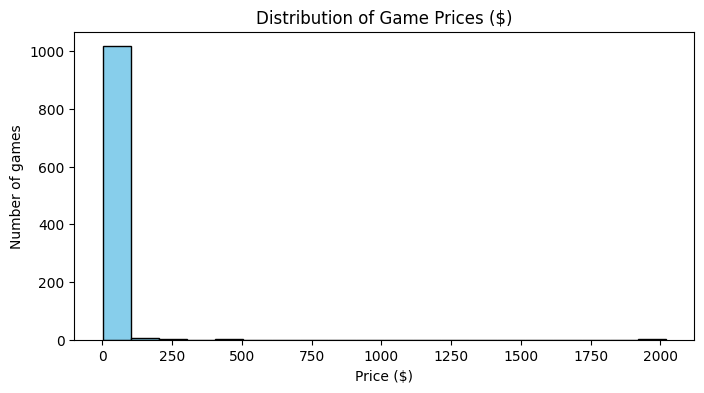

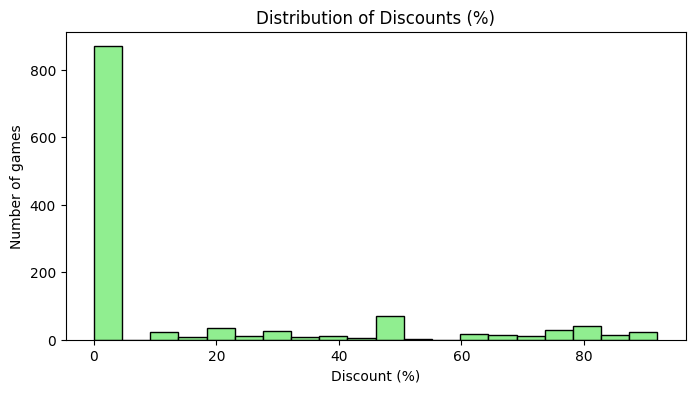

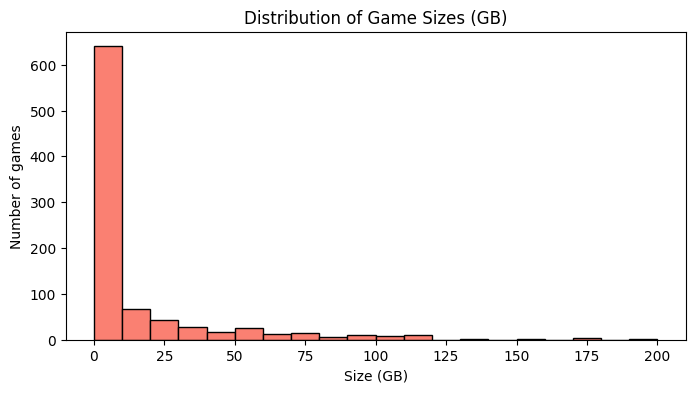

In [ ]:
import json
import matplotlib.pyplot as plt
import re
from statistics import mean, median, stdev
from collections import Counter

# Load the dataset
with open("/content/dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# --- Helper functions ---

def parse_price(price_str):
    """Convert price like '$29.99' to float"""
    try:
        num = float(re.findall(r"[\d\.]+", price_str.replace(",", ""))[0])
        return num
    except:
        return None

def parse_discount(discount_str):
    """Convert discount like '20%' to float"""
    try:
        num = float(re.findall(r"[\d\.]+", discount_str)[0])
        return num
    except:
        return 0.0

def parse_size(size_str):
    """Convert size like '18.3 GB' or '1024 MB' to float GB"""
    try:
        num = float(re.findall(r"[\d\.]+", size_str)[0])
        if "GB" in size_str.upper():
            return num
        elif "MB" in size_str.upper():
            return num / 1024
        else:
            return num
    except:
        return None

# --- Extract numeric fields ---
prices = [parse_price(entry.get("base_price", "")) for entry in data]
prices = [p for p in prices if p is not None]

discounts = [parse_discount(entry.get("discount", "")) for entry in data]

sizes = [parse_size(entry.get("size", "")) for entry in data]
sizes = [s for s in sizes if s is not None]

# --- Compute basic statistics ---
def print_stats(name, values):
    if not values:
        print(f"{name}: No data")
        return
    print(f"--- {name} ---")
    print(f"Count: {len(values)}")
    print(f"Mean: {mean(values):.2f}")
    print(f"Median: {median(values):.2f}")
    try:
        mode_val = Counter(values).most_common(1)[0][0]
    except IndexError:
        mode_val = "No mode"
    print(f"Mode: {mode_val}")
    print(f"Min: {min(values):.2f}")
    print(f"Max: {max(values):.2f}")
    if len(values) > 1:
        print(f"Std dev: {stdev(values):.2f}")
    print()

print_stats("Base Price ($)", prices)
print_stats("Discount (%)", discounts)
print_stats("Size (GB)", sizes)

# --- Plot histograms ---
def plot_histogram(values, title, xlabel, color):
    plt.figure(figsize=(8,4))
    plt.hist(values, bins=20, color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Number of games")
    plt.show()

plot_histogram(prices, "Distribution of Game Prices ($)", "Price ($)", "skyblue")
plot_histogram(discounts, "Distribution of Discounts (%)", "Discount (%)", "lightgreen")
plot_histogram(sizes, "Distribution of Game Sizes (GB)", "Size (GB)", "salmon")


#### Qualidade dos Dados

In [ ]:
import json
from collections import Counter, defaultdict
import statistics
import re

# Load unified JSON
with open("/content/dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# ===== Structural Analysis =====
print("=== STRUCTURAL ANALYSIS ===")
all_keys = set()
for entry in data:
    all_keys.update(entry.keys())
all_keys = sorted(all_keys)
print(f"Attributes (fields): {all_keys}")
print(f"Number of entries: {len(data)}")

# Determine types and missing values
types_count = defaultdict(Counter)
missing_count = defaultdict(int)
lengths = defaultdict(list)

for entry in data:
    for key in all_keys:
        value = entry.get(key)
        if value is None:
            missing_count[key] += 1
        else:
            types_count[key][type(value).__name__] += 1
            if isinstance(value, str):
                lengths[key].append(len(value))
            elif isinstance(value, list):
                lengths[key].append(len(value))

print("\nField types:")
for key, counts in types_count.items():
    print(f"{key}: {dict(counts)}")

print("\nMissing values per field:")
for key, count in missing_count.items():
    print(f"{key}: {count} missing ({count/len(data)*100:.2f}%)")

print("\nAverage length of entries (chars or list length):")
for key, lens in lengths.items():
    if lens:
        avg_len = sum(lens) / len(lens)
        print(f"{key}: {avg_len:.2f}")

# ===== Descriptive Statistics =====
print("\n=== DESCRIPTIVE STATISTICS ===")
for key in all_keys:
    values = [entry.get(key) for entry in data if entry.get(key) is not None]

    if not values:
        continue

    # String / categorical
    if isinstance(values[0], str):
        counter = Counter(values)
        most_common = counter.most_common(5)
        print(f"\nField '{key}' (string/categorical):")
        print(f" - Top 5 values: {most_common}")
        print(f" - Unique values: {len(counter)}")

    # List fields
    elif isinstance(values[0], list):
        flat = [item.strip() for sublist in values for item in sublist if item]
        counter = Counter(flat)
        most_common = counter.most_common(5)
        print(f"\nField '{key}' (list):")
        print(f" - Top 5 values: {most_common}")
        print(f" - Unique values: {len(counter)}")

    # Numeric fields
    elif isinstance(values[0], (int, float)):
        print(f"\nField '{key}' (numeric):")
        print(f" - Mean: {statistics.mean(values):.2f}")
        print(f" - Median: {statistics.median(values):.2f}")
        try:
            mode_val = statistics.mode(values)
        except statistics.StatisticsError:
            mode_val = "No unique mode"
        print(f" - Mode: {mode_val}")
        print(f" - Std dev: {statistics.stdev(values):.2f}")
        print(f" - Min: {min(values)}")
        print(f" - Max: {max(values)}")

# ===== Data Quality Checks =====
print("\n=== DATA QUALITY CHECKS ===")

# Detect duplicates (game_title + source), ignoring None titles
seen = set()
duplicates = []
null_titles = 0

for entry in data:
    game_title = entry.get("game_title")
    source = entry.get("source")

    if game_title is None:
        null_titles += 1
        continue  # skip this entry for duplicate detection

    identifier = (game_title, source)
    if identifier in seen:
        duplicates.append(identifier)
    else:
        seen.add(identifier)

print(f"Entries with null game_title: {null_titles}")
print(f"Duplicate entries (non-null game_title + source): {len(duplicates)}")
if duplicates:
    print("Sample duplicates:", duplicates[:5])

# Inconsistent formatting
print("\nPotential formatting issues:")
for key in ["tags", "supported_os", "release_date", "base_price", "actual_price", "discount"]:
    sample_values = [entry.get(key) for entry in data if entry.get(key)]
    if key == "tags":
        trailing_comma = [v for sublist in sample_values if isinstance(sublist, list) for v in sublist if v.strip().endswith(",")]
        if trailing_comma:
            print(f" - Field '{key}' has entries with trailing commas (sample): {trailing_comma[:5]}")
    if key == "supported_os":
        odd_format = [v for sublist in sample_values if isinstance(sublist, list) for v in sublist if re.search(r"\(.*\)", v) is None]
        if odd_format:
            print(f" - Field '{key}' may have inconsistent OS formatting (sample): {odd_format[:5]}")

# ===== Outlier Detection =====

# Helper to parse size string to GB
def parse_size(size_str):
    try:
        num = float(re.findall(r"[\d\.]+", size_str)[0])
        if "GB" in size_str.upper():
            return num
        elif "MB" in size_str.upper():
            return num / 1024
        else:
            return num
    except:
        return None

# Helper to parse price string to float
def parse_price(price_str):
    try:
        num = float(re.findall(r"[\d\.]+", price_str.replace(",", ""))[0])
        return num
    except:
        return None

# Collect numeric values
sizes = [(i, parse_size(entry.get("size", ""))) for i, entry in enumerate(data) if entry.get("size")]
sizes = [(i, s) for i, s in sizes if s is not None]

prices = [(i, parse_price(entry.get("base_price", ""))) for i, entry in enumerate(data) if entry.get("base_price")]
prices = [(i, p) for i, p in prices if p is not None]

# Detect outliers using mean ± 3*std
def detect_outliers(values):
    if not values:
        return []
    vals = [v for i, v in values]
    mean_val = statistics.mean(vals)
    stdev_val = statistics.stdev(vals) if len(vals) > 1 else 0
    outliers = [(i, v) for i, v in values if v > mean_val + 3*stdev_val or v < mean_val - 3*stdev_val]
    return outliers

size_outliers = detect_outliers(sizes)
price_outliers = detect_outliers(prices)

print(f"\nSize outliers (GB): {len(size_outliers)}")
for i, s in size_outliers[:5]:
    print(f" - Example: game_title='{data[i]['game_title']}', size='{data[i]['size']}'")

print(f"\nBase price outliers ($): {len(price_outliers)}")
for i, p in price_outliers[:5]:
    print(f" - Example: game_title='{data[i]['game_title']}', base_price='{data[i]['base_price']}'")

print("\nAnalysis complete.")


=== STRUCTURAL ANALYSIS ===
Attributes (fields): ['actual_price', 'base_price', 'description', 'developers', 'discount', 'game_title', 'genres', 'release_date', 'size', 'source', 'supported_os', 'tags', 'timestamp']
Number of entries: 1220

Field types:
actual_price: {'str': 1072}
base_price: {'str': 1072}
description: {'str': 1220}
developers: {'list': 1220}
discount: {'str': 1128}
game_title: {'str': 1132}
genres: {'list': 1220}
release_date: {'str': 1101}
size: {'str': 1089}
source: {'str': 1220}
supported_os: {'list': 1220}
tags: {'list': 1220}
timestamp: {'str': 1220}

Missing values per field:
release_date: 119 missing (9.75%)
actual_price: 148 missing (12.13%)
base_price: 148 missing (12.13%)
size: 131 missing (10.74%)
discount: 92 missing (7.54%)
game_title: 88 missing (7.21%)

Average length of entries (chars or list length):
actual_price: 5.75
base_price: 5.86
description: 1657.15
developers: 1.39
discount: 2.62
game_title: 25.29
genres: 2.75
release_date: 13.37
size: 4.32
so